# Experiments to find which binary models perform best

In [16]:
import time
import os
import glob
import re
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

import ray

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [17]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [18]:
run_experiments = True

In [19]:
incerto_dir = os.path.join(os.getcwd(), '..', '..')
output_dir = os.path.join(incerto_dir, 'output')
performance_dir = os.path.join(output_dir, 'classification-performance')
figures_dir = os.path.join(incerto_dir, 'figures')

## Set up

In [20]:
scalers = {'StandardScaler': StandardScaler(),
           'L1': Normalizer(norm='l1'),
           'L2': Normalizer(norm='l2')}

In [21]:
def build_vectorizer(_typ, _ngram, _max, _min, _max_f):

    if _max_f == 'None':
        _max_f = None

    if _typ == 'Count':
        vec = CountVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2],
                    max_df=_max,
                    min_df=_min,
                    max_features=_max_f)

    elif _typ == 'TfIdf':
        vec = TfidfVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2],
                    max_df=_max,
                    min_df=_min,
                    max_features=_max_f,
                    norm=None)
    return vec

In [22]:
matrix_options = {'vectorizer':['Count', 'TfIdf'],
           'ngram': [['Char','Bigrams', (2,2)],['Char','Trigrams', (3,3)],['Word','Unigrams', (1,1)]],
           'max_df': [0.8,0.9,1.0],
           'min_df': [0.0,0.1,0.2],
           'max_f': ['None', 1000],
           'scaler': scalers.keys()}

In [23]:
total = matrix_options.values()
matrix_combos = list(product(*total))
print(len(matrix_combos))
matrix_combos[0]

324


('Count', ['Char', 'Bigrams', (2, 2)], 0.8, 0.0, 'None', 'StandardScaler')

In [24]:
classifiers = {
  'RandomForest': RandomForestClassifier(),
  'kNN': KNeighborsClassifier(),
  'Logit': LogisticRegression(),
  'SVM': SVC()}

## Experiments

In [25]:
if run_experiments == True:
    ray.init(num_cpus=8)

2025-07-20 22:19:35,857	INFO worker.py:1888 -- Started a local Ray instance.


In [26]:
@ray.remote
def do_classification(_combo, _scaled_X, _golden_labels, _classifiers, _classifier, _author, _num_f, _typ, _path): #, _models_done):
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    scores = cross_validate( # perform cross-validation
            _classifiers[_classifier], # classifier object
            _scaled_X, # feature matrix
            _golden_labels, # gold labels
            cv=cv, #number of folds
            scoring=['f1_macro']) # scoring methods
    scores_df = pd.DataFrame(scores).mean()

    with open(_path, 'a') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow((_classifier, _author, _combo[0],
                            _combo[1][0], _combo[1][1],
                            _combo[2], _combo[3], _combo[4], _num_f,
                            _combo[5], scores_df.loc['test_f1_macro'], _typ))
    
    # with open("models_done.txt", "a") as f:
    #     f.write(f"{_author}_{_combo}_{_classifier}" + "\n")

In [27]:
# 15 is the number of authors we are training on and 2 is the number of poem types
(len(matrix_combos)*len(classifiers.keys())*11*2)+(len(matrix_combos)*len(classifiers.keys())*3*1)

32400

In [28]:
poems_path = os.path.join(incerto_dir, 'data', 'poems', f'poems_whole.csv')
all_poems_df = pd.read_csv(poems_path)
len(all_poems_df.author.unique())

15

In [29]:
classification_path = os.path.join(performance_dir, f'binary_classification_performance.csv')
if not os.path.exists(classification_path):
    with open(classification_path, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(('classifier', 'author', 'vectorizer',
                            'ngram type', 'ngram range',
                            'max_df', 'min_df', 'max_f', 'num_f',
                            'scaler', 'f1-score', 'type'))

In [30]:
# if os.path.exists("models_done.txt"):
#     with open( "models_done.txt", "r") as f:
#         models_done = [line.strip() for line in f]
# else:
#     models_done = []

if run_experiments == True:

    for typ in ['Split', 'Whole']:

        poems_path = os.path.join(incerto_dir, 'data', 'poems', f'poems_{typ.lower()}.csv')
        all_poems_df = pd.read_csv(poems_path)
        print(f'All {typ} poems:\t', len(all_poems_df))
        poems_df = all_poems_df.loc[all_poems_df['author'] != 'UnknownAuthor']
        print(f'Known {typ} poems:\t', len(poems_df))

        for combo in matrix_combos:

            if combo[1][0] == 'Char':
                poems = [re.sub(r'\s+', '', x) for x in poems_df['poem'].tolist()]
            elif combo[1][0] == 'Word':
                poems = poems_df['poem'].tolist()
            vectorizer = build_vectorizer(combo[0], combo[1], combo[2], combo[3], combo[4])

            X = vectorizer.fit_transform(poems)
            num_f = X.shape[1]
            scaled_X = scalers[combo[5]].fit_transform(X.toarray())

            for author in poems_df['author'].unique():
                
                if not (typ == 'Whole' and author in ["MaffioVenier","MarcoStecchini","BartolomeoZacco"]):

                    futures = []

                    golden_labels = poems_df['author'].map(lambda x: 1 if x==author else 0).tolist()

                    for classifier in classifiers.keys():
                        
                        # if f"{author}_{combo}_{classifier}" not in models_done:

                            # do_classification(combo, scaled_X, golden_labels, classifiers, classifier, author, num_f, typ, classification_path, models_done)

                        futures.append(do_classification.remote(combo, scaled_X, golden_labels, classifiers, classifier, author, num_f, typ, classification_path))#, models_done))

                    results = ray.get(futures)

All Split poems:	 1176
Known Split poems:	 1116


KeyboardInterrupt: 

In [ ]:
typ = "Whole"
author = "VeronicaFranco"
if not (typ == 'Whole' and author in ["MaffioVenier","MarcoStecchini","BartolomeoZacco"]):
    print('yes')
else:
    print('no')

yes


## Evaluating overall performance

In [32]:
performance_path = os.path.join(performance_dir, f'binary_classification_performance.csv')
results_df = pd.read_csv(performance_path)
print(len(results_df))
results_df.head()

32400


,classifier,author,vectorizer,ngram type,ngram range,max_df,min_df,max_f,num_f,scaler,f1-score,type
0,Logit,AntonGiacomoCorso,Count,Char,Bigrams,0.8,0.0,NaN,259,StandardScaler,0.649688,Split
1,kNN,AntonGiacomoCorso,Count,Char,Bigrams,0.8,0.0,NaN,259,StandardScaler,0.518690,Split
2,SVM,AntonGiacomoCorso,Count,Char,Bigrams,0.8,0.0,NaN,259,StandardScaler,0.486660,Split
3,RandomForest,AntonGiacomoCorso,Count,Char,Bigrams,0.8,0.0,NaN,259,StandardScaler,0.486660,Split
4,Logit,BartolomeoZacco,Count,Char,Bigrams,0.8,0.0,NaN,259,StandardScaler,0.498877,Split


In [39]:
for author in results_df.author.unique():
  n = len(results_df[(results_df['author'] == author) & (results_df['f1-score'] >= 0.7)])
  print(author, n)

AntonGiacomoCorso 0
BartolomeoZacco 0
CelioMagno 0
DomenicoVenier 36
GiorgioGradenigo 0
MaffioVenier 49
MarcoStecchini 0
MarcoVenier 0
MuzioManfredi 42
OrsattoGiustinian 9
Petrarca 158
PietroBembo 4
ValerioSali 0
VeronicaFranco 394


In [33]:
performance_path2 = os.path.join(performance_dir, f'multi_classification_performance.csv')
results_df2 = pd.read_csv(performance_path)
print(len(results_df)+len(results_df2))

64800


In [34]:
for author in results_df.author.unique():
  av = results_df.loc[results_df['author'] == author][['f1-score']].mean()
  print(author, av)

AntonGiacomoCorso f1-score    0.499252
dtype: float64
BartolomeoZacco f1-score    0.498873
dtype: float64
CelioMagno f1-score    0.490214
dtype: float64
DomenicoVenier f1-score    0.526888
dtype: float64
GiorgioGradenigo f1-score    0.49658
dtype: float64
MaffioVenier f1-score    0.512408
dtype: float64
MarcoStecchini f1-score    0.495623
dtype: float64
MarcoVenier f1-score    0.497082
dtype: float64
MuzioManfredi f1-score    0.501306
dtype: float64
OrsattoGiustinian f1-score    0.487697
dtype: float64
Petrarca f1-score    0.519201
dtype: float64
PietroBembo f1-score    0.506884
dtype: float64
ValerioSali f1-score    0.497508
dtype: float64
VeronicaFranco f1-score    0.562681
dtype: float64


In [35]:
baselines = pd.read_csv(os.path.join(performance_dir, 'binary_baseline.csv'))
baselines

,Author,Poem format,Naive Classifier Type,F-1 score
0,AntonGiacomoCorso,Split,Majority,0.487358
1,AntonGiacomoCorso,Whole,Majority,0.488066
2,BartolomeoZacco,Split,Majority,0.498935
3,BartolomeoZacco,Whole,Majority,0.497982
4,CelioMagno,Split,Majority,0.487582
5,CelioMagno,Whole,Majority,0.485099
6,DomenicoVenier,Split,Majority,0.481253
7,DomenicoVenier,Whole,Majority,0.472882
8,GiorgioGradenigo,Split,Majority,0.497221
9,GiorgioGradenigo,Whole,Majority,0.494720


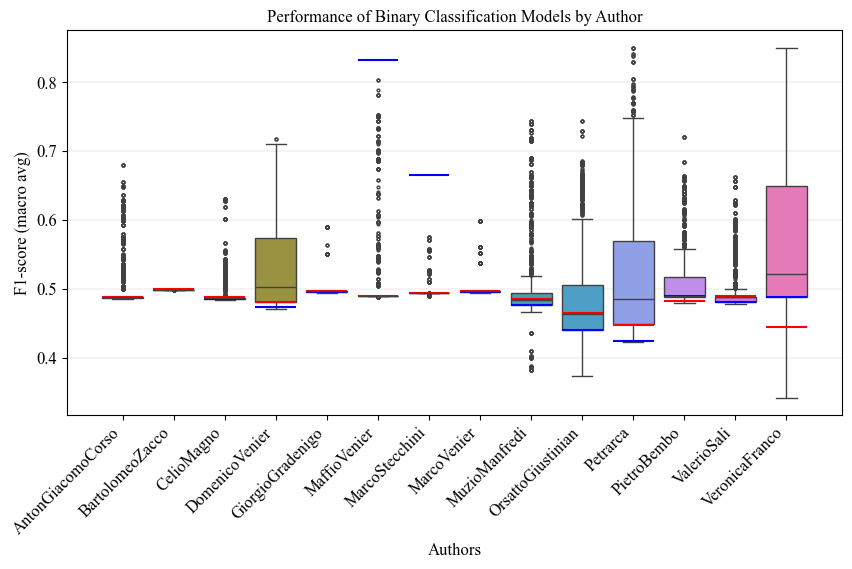

In [36]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='author', y='f1-score', data=results_df, hue='author',
                 fliersize=2)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

for typ, clr in {'Whole': 'blue', 'Split': 'red'}.items():
  tick = 0
  for author in results_df.author.unique():
    baseline = baselines[(baselines['Author'] == author) & (baselines['Poem format'] == typ)]['F-1 score'].values[0]
    if author=='Franco' and typ=='Whole':
      baseline -= 0.001
    xmin = tick -0.4
    xmax = tick +0.4
    ax.hlines(baseline, xmin, xmax, color=clr)
    tick += 1

plt.xticks(rotation=45, ha='right')
# plt.ylim(0.4,0.6)
plt.title('Performance of Binary Classification Models by Author', size=12)
plt.ylabel('F1-score (macro avg)')
plt.xlabel('Authors')
plt.savefig(os.path.join(figures_dir, 'performance.png'), dpi = 300, bbox_inches = "tight")
plt.show()

In [9]:
def make_figure(hue_label):

    plt.figure(figsize=(15, 5))
    ax = sns.boxplot(x='author', y='f1-score', data=results_df, hue=hue_label.lower())
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(hue_label)
    plt.ylabel('F1-score (macro avg)')
    plt.title(f'Performance of different {hue_label.lower()}s')
    plt.show()

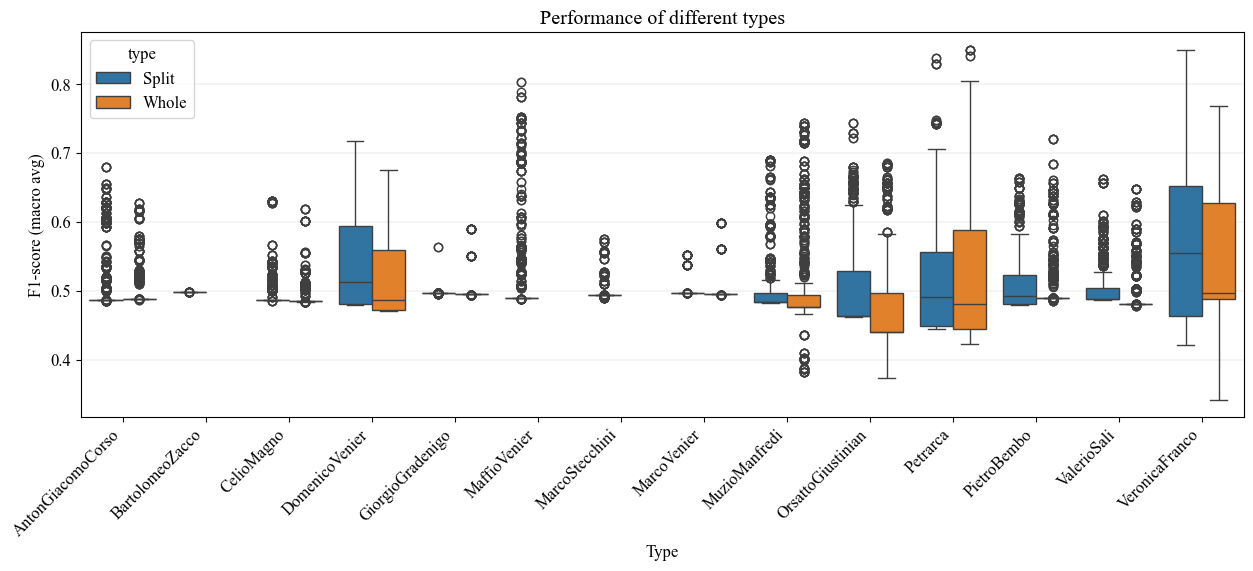

In [10]:
make_figure('Type')

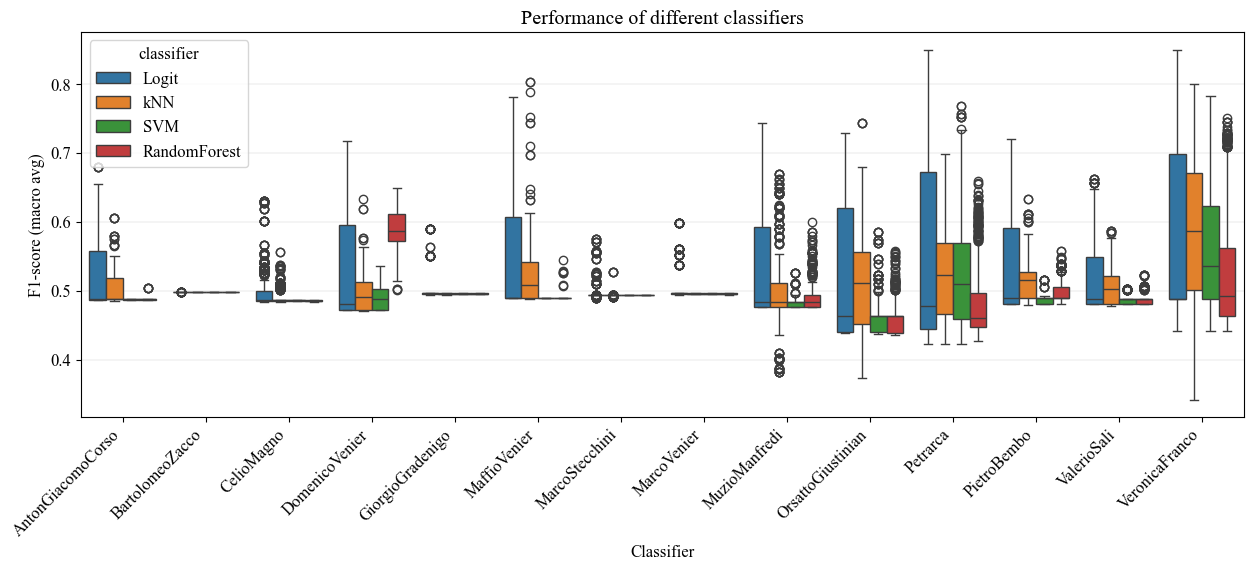

In [11]:
make_figure('Classifier')

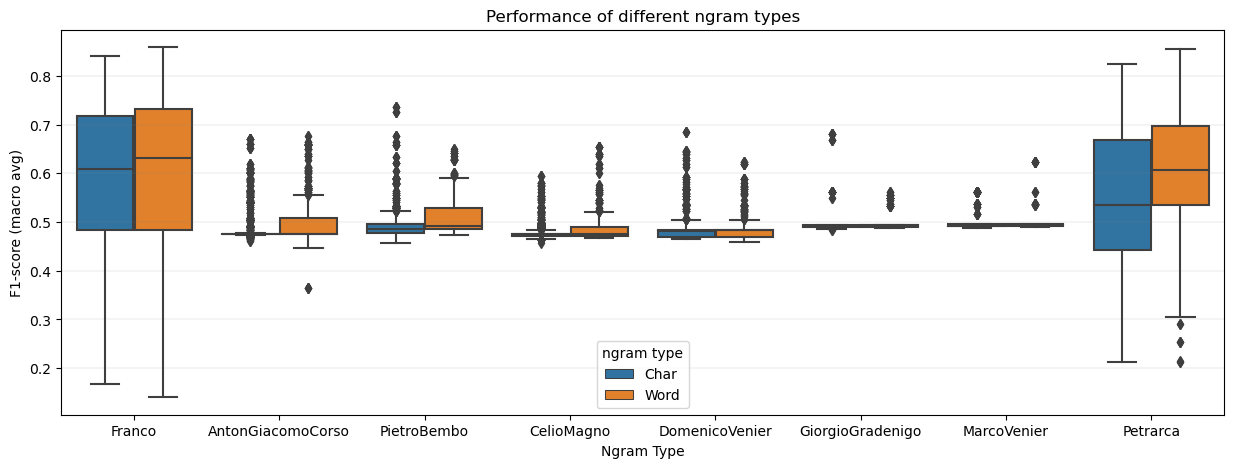

In [ ]:
make_figure('Ngram Type')

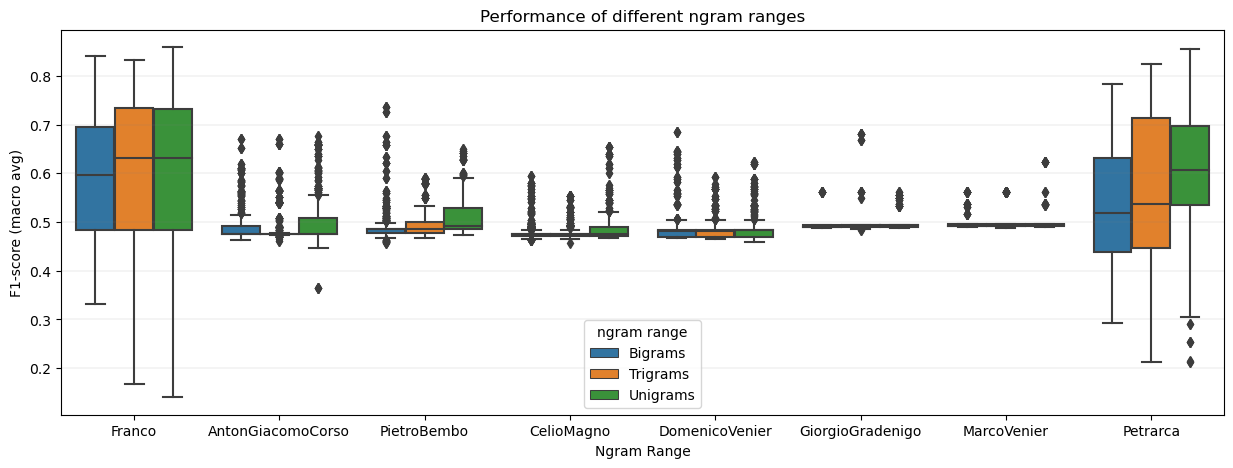

In [ ]:
make_figure('Ngram Range')

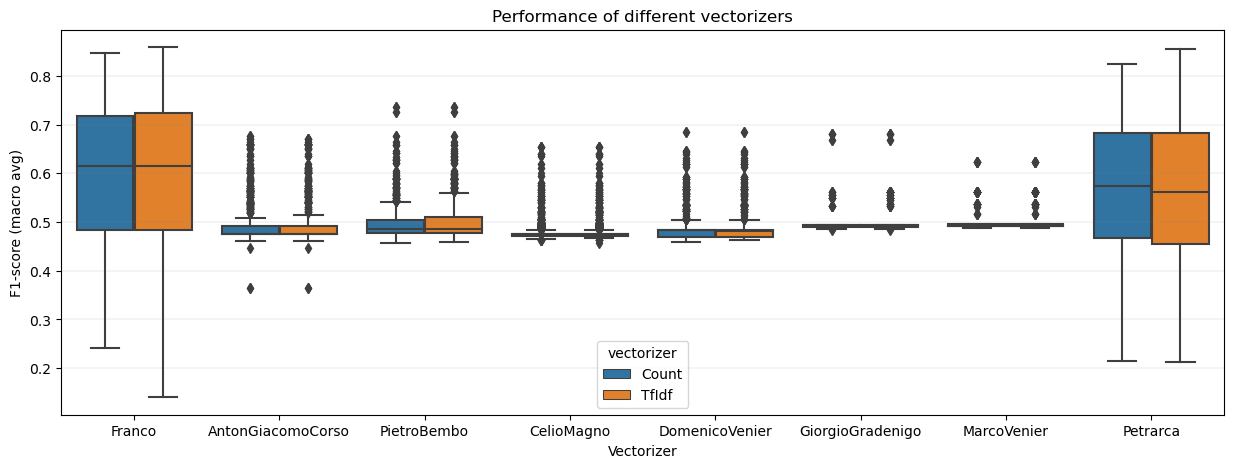

In [ ]:
make_figure('Vectorizer')

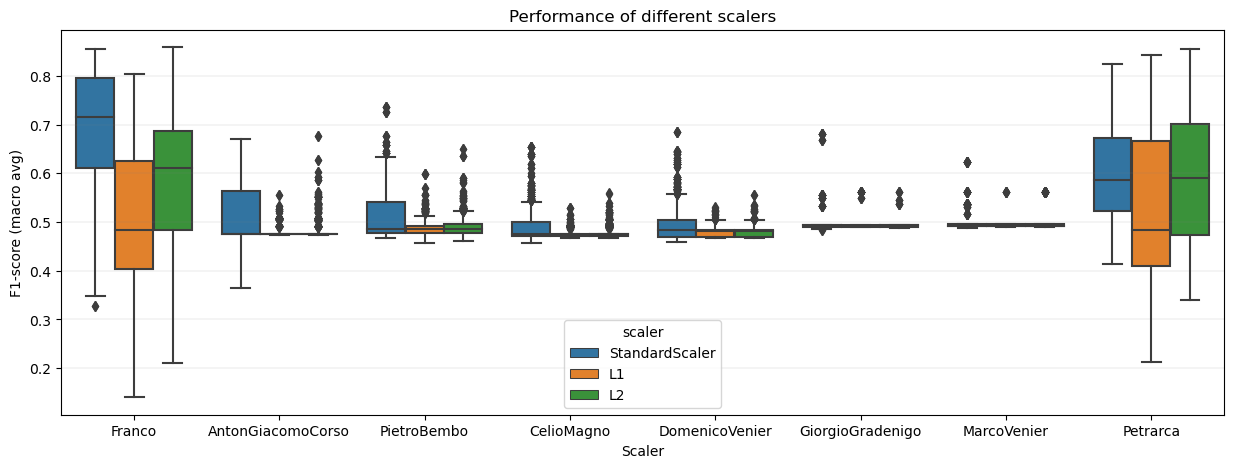

In [ ]:
make_figure('Scaler')